# This notebook is just for notes - there will be an actual notebook that has everything we want so it is cleaner and nicer and will include the notes in my README

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

> Notes
- **Micrograd** is a library that Andrej released on GitHub, which is an *Autograd* engine (short for automatic gradient). It implements backpropagation
	- Scalar valued autograd engine, so it's working on the level of individual scalars (like -4 and 2) and we're taking NNs and breaking them down all the way to these "atoms" of individual scalars
	- Allows you to build out mathematical expressions; add, multiple, raise them to a constant power, offset by 1, negate, squash at 0 (.relu()), square, divide by constant, divide, etc
    - Figuring out the derative of a, `print(f'{a.grad:.4f}')`, and b, `print(f'{b.grad:.4f}')`, is important because it's telling us how a and b are affecting g, `g.backward()`, through the chain rule mathematical expression of backpropagation
	- **How will g respond if a and b get tweaked a bit a tiny amount in a positive direction:** 
		- a.grad = 138.8, so, if slightly nudge a and make it slightly larger (the value), 138 is telling us that g will grow and that slope of that growth is going to be 138
		- b.grad = 645.6, so, the slope of growth of b is going to be 645.6
- **What is backpropagation?** An algorithm that allows you to efficiently evaluate the gradient of some kind of loss function with respect to the weights of a NN. It's the mathematical core of any modern deep NN library (PyTorch, JAX, etc)
	- We can iteratively tune the weights of the NN to minimize the loss function to improve the accuracy of the NN
- NNs are just mathematical expressions like the one above but can be slightly less crazy
	- Takes the input data (as input) and the weights of a NN (as input) and its mathematical expression and the output are your predictions of your NN or loss function
	- NNs are a certain class of mathematical expressions but back propagation is more general, it doesn't care about NNs at all, it only tells us about arbitrary mathematical expressions and we happen to use that machinery for training of NNs
- If you want to train bigger networks you have to be using tensors, basically taking scale values, packaging up into tensors (arrays of these scalars), because we have these large arrays, we're making operations on, allows us to take advantage of the parallelism in a computer aka run faster
	- Just for efficiency but the math is the same as back propagation
- **Rare Andrej take:** Micrograd is what you need to train your networks and everything else is just efficiency
- Looking into the micrograd folder within GitHub:
	- Only two files: engine.py and nn.py
	- engine.py doesn't know anything about neural nets (autograd engine that gives you the power of NNs). 100 lines of code
	- nn.py is the entire NNs library on top of micrograd (autograd engine). Defines what is a neuron, layer of neurons, and multi-layer perceptron (MLP - sequence of layers of neurons). 150 lines of code
- `a*b + c` = `a.__mul__(b)).__add__(c)`
- `d._prev` = `((a*b), c) = {Value(data=-6.0), Value(data=10.0)}`
- `d._op` = `'+'`

**Neural networks are massive mathematical expressions, we need some data structures that maintain these expressions**

The class value has the full mathematical expression. This data structure knows exactly how each value came to be by word expression and from what other values:

In [45]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # Intially assumes no impact on output
        self._backward = lambda: None # Placeholder for backpropagation function
        self._prev = set(_children) # Set of previous values
        self._op = _op # Operation used to create this value
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        
    
#a = Value(2.0, label='a')
#b = Value(-3.0, label='b')
#c = Value(10.0, label='c')
#e = a*b; e.label = 'e'
#d = e + c; d.label = 'd'
#f = Value(-2.0, label='f')
#L = d * f; L.label= 'L'
#L

In [23]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

This class nicely visualizes the expressions that are being built out:

The cell below creates a new function, draw_dot, that we can call on a root node and then it visualizes it

In [43]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

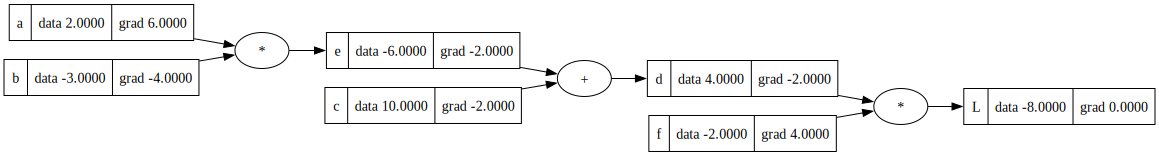

In [7]:
draw_dot(L) # output of the forward pass composed of scalar values is -8

> Notes
- Back propagation = reverse from L and calculate the gradient from all the intermediate values = for every single value we are going to compute the derivative of that node with respect to L
- Derivative of L with respect to L is 1
- Derivative of L with respect to F, D, E, C, B, and A = gradient
- In the NN setting you'd be interested in the derivative of this loss function, L, with respect the weights of a NN
- We have the variables, A, B, C, D, E, F but will eventually represent the weights of a NN so we'll need to know how the weights are impacting the loss function = derivative of the output with respect to some of its leaf nodes and the leaf nodes will be the weights of the NN while the other leaf nodes will be the data itself but we will usually not want or use the derivative of the loss function with respect to data because the data is fixed but the weights will be iterated on using the gradient information
- If we want L to go up, we have to go in the direction of the gradient
- A, B, C, and F are leaf nodes, which we have control so we can change L

> We know:
- L = d * f

> We'd like to know:
- dL/dd = ? f
- ddf/dd = f
- dL/df = d - symmetrically
---
**Deriving dL/dd:**
- (f(x-h) - f(x))/h
- ((d+h)*f - d*f)/h
- (d*f + h*f - d*f)/h
- (h*f)/h
- f
---
**Deriving dd/dc and dd/de to figure out dL/dc and dL/de:**
- How do we derive dL/dc? We know the derivative L with respect to d, but how is L sensitive to c? (If we wiggle c how does that impact L through d)
- If we know the impact c is having on d and the impact that d is having on L, then we will know the impact c is having on L by using the chain rule from calculus
- dd/dc = ? 1.0
- d = c + e
- (f(x+h) - f(x))/h -- aka the print statement in lol()
- ((c+h + e) - (c+e))/h
- (c + h + e - c - e)/h
- h/h = 1.0
- By symmetry: dd/de = 1.0
- These are called the local derivative because the final output value is at the end of the graph and we have now transitioned to a small isolated node. The + node on the right could be embedded in a massive graph, the + node just routes the gradient to the local gradient (children nodes)

- Can confirm the math by adding h to f in lol() to get 4 (data of -2.0) and by adding h to d in lol() to get -2 (data of 4) to represent an inline gradient check
- A gradient check is when we are deriving this back propagation and getting the derivative with respect to all the intermediate results
- Numerical gradient is when we are estimating it using a small step size (`h = 0.001`)
> Want:
- dL/dc
- dL/de
> Know:
- dL/dd = -2.0
- dd/dc = 1.0
> Using chain rule to find dL/dc:
- dL/dc = (dL/dd) * (dd/dc) = (-2.0) * (1.0) = (-2.0)
---
> Want:
- dL/da = (dL/de) * (de/da) = -2.0 * -3.0 = 6
- dL/db = (dL/de) * (de/db) = -2.0 * 2 = -4
> Know:
- dL/dc = -2.0
- dL/de = -2.0
- dL/dd = -2.0
- dL/df = 4.0
- e = a*b
- f(x) - f(x)/h = ((a+h)b - (a*b))/h = (ab + bh - ab)/h = b = -3.0

In [5]:
d.grad = -2.0 # Manual back propagation
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [6]:
def lol():
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label= 'L'
    L1 = L.data # originally value node so we want it's data so they are floats
    
    # Measuring the derivative of 'L' with respect to 'a'
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label= 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()

0.0


^ The above is manual back propagation of a simple expression

Below we are going to manually do back propagation through a neuron:

> Notes
- We are going to build out neural networks and in the simplest case these are multilayer perceptrons (MLP)

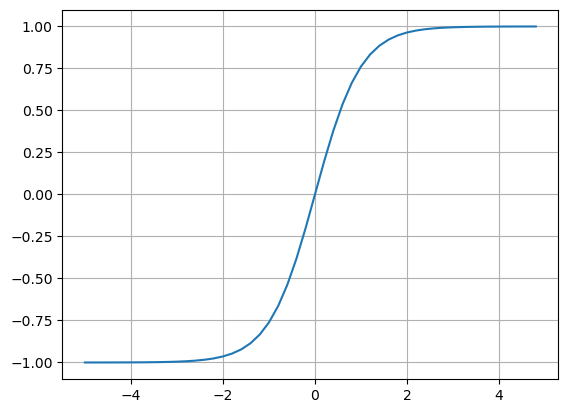

In [8]:
# Hyperbolic function that needs exponentiation and division to create
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

> The above plot is the tanh function. The inputs as they come in get squashed on the Y coordinate, right at 0 we get 0, and then as we go more positive in the input then the function is capped at one. So when passing very positive inputs we're gonna cap it smoothly at one (vice versa for negative)

In [26]:
# inputs x1, x2 (2D)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2, of the neuron (synaptic strengths for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b ('cell body of neuron')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output
o = n.tanh(); o.label = 'o'

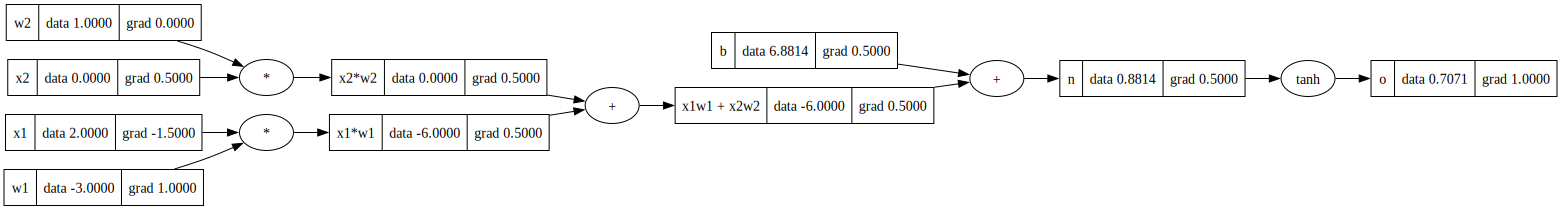

In [29]:
draw_dot(o)

In [28]:
o.backward()

> Notes
- Bias is low (6.7) so the tanh function is not squashing n (0.7) too much but if we were to raise the bias up then tanh would be closer to one
- We are going to perform back propagation and we are going to fill in all the gradients. What is the derivative o with respect to all the inputs
- In a typical NN setting what we really care about the most is the derivative of the neurons on the weights specifically because those are the values that are iterated through as part of the optimization which we eventually get a loss function that measures the accuracy of the NN and we are back propagating with respect to that accuracy and trying to increase it
- Here we have a single neuron but in a NN we have many and they're connected
- If we want this neurons output to increase, w2 doesn't matter since there is no gradient (slope), but the w1 weight node should go up so the neurons output can go up too and proportionally because the gradient is one

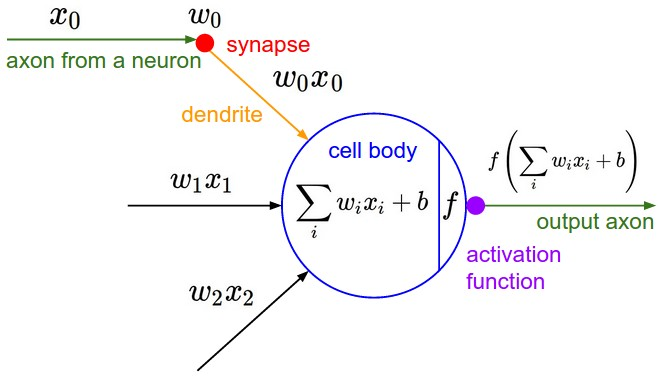

> Notes when figuring out the derivative via back propagation
- Remember, the outputs derivative is always 1.0
---

Want:
- Derivative of o with respect to n
- do/dn = 1 - tanh(n)**2 = 1 - 0.7071**2 = 0.5

Know:
- o = tanh(n)
---

Want:
- Derivative of o with respect to x1w1 + x2w2
- Derivative of o with respect to b
- do/dx1w1x2w2 = 0.5
- do/db = 0.5

Know:
- Remember, that the + is just a distributor of the gradient
- Same concept will apply to the next children nodes (x2w2, x1w1)
---

In [11]:
# Manual back propagation by manually deriving the values
#o.grad = 1.0
#n.grad = 0.5
#x1w1x2w2.grad = 0.5
#b.grad = 0.5
#x1w1.grad = 0.5
#x2w2.grad = 0.5
#x2.grad = w2.data * x2w2.grad
#w2.grad = x2.data * x2w2.grad
#x1.grad = w1.data * x1w1.grad
#w1.grad = x1.data * x1w1.grad

> Notes
- Now we are going to implement backward pass (back propagation) automatically instead of doing it manually like above (check out the value object)
- We added a self._backward that is a function which does the chain rule at each node that took inputs and produced output. We are going to store how we are going to chain the output gradient into the input gradient
- The function is a lambda: None which does nothing. This is done for something like a leaf node where there is nothing to do (like b since it is a leaf node aka not connected to anything)
- As a base case, we need to set the grad to 1.0 because in the value object we have it set to 0.0 so we can intialize it with 1
- We never want to call a ._backward for any node before we have done everything after it. We have to get all of its full dependencies before we back propagate
- The ordering of graphs can be achieved using **topolocial sort** which is a laying out of a graph such that all the edges go only from left to right

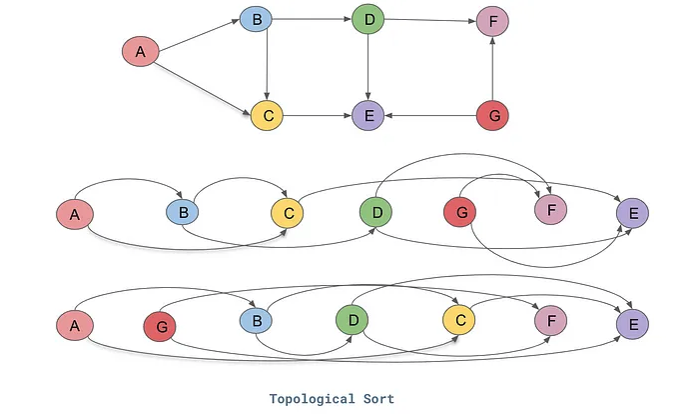

- To build a topological graph:
    - Maintain a set of visited nodes (`visited = set()`)
    - We start at some root node, which for us is o (but it's the output), we go through all of its children and we need to lay them out from left to right
    - If it's not visited then marks it as visited and then iterates through all of its children and calls `build_topo` on them
    - After its gone through all the children it adds itself, so adds the o to the list after all the children have been processed
    - This function guarantees that you're only going to be in the list once all your children are in the list and that's the invariant that is being maintained
    - What this is doing is we're call ._backward on all of the nodes in a topological order

In [17]:
# Manual implementation of back propagation for each operation
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

- Fixing a bug:
- Simplest case that shows the bug is below
- The forward pass works because b = a + a, so the value for b is 6
- The problem is, the gradient for a is not correct
- The derivative of b with respect to a should be 2
    - 1.0 + 1.0
- What is happening here?
    - B is the result of a + a
    - We called backward on it
    - Looking at __add__ function, we are overriding the gradient when doing `self.grad = 1.0 * out.grad` and `other.grad = 1.0 * out.grad`

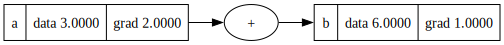

In [34]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

- More complicated expression to see the bug:
- We're going to see an issue anytime we use a variable more than once, until now, every variable is used exactly once so we didn't see the issue
- If a variable is used more than once, what's going to happen during backward pass?
    - We're back propagating from f, to e to d, so that is fine, but since e is a + it'll flow the gradient to b and a, but they're both used for d as well and that has *. d overrights the gradients at a and b from e
- Solution: look at multivariable case of the chainrule
    - We have to accumulate the gradients (add) aka chaing the `self.grad = 1.0 * out.grad` and `other.grad = 1.0 * out.grad` to `self.grad += 1.0 * out.grad` and `other.grad += 1.0 * out.grad`
    - This is okay because we are initializing them at 0 (self.grad = 0.0)
    - They start at 0 and then any contribution that flows backwards will simply add ontop of each other. gradient a + gradient b from gradient d, gradient a + gradient b from gradient e

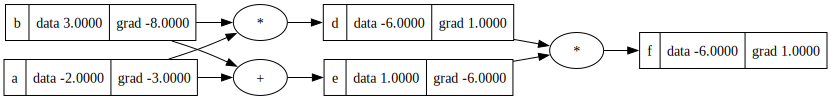

In [35]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

> Notes
- We developed tanh as a single function and we can do that because we know its derivative and we can back propagate through it but we can also break down tanh and express it as a function of x
    - Utilizing the hyperbolic tangent
- Breaking down tanh forces us to implement a few more expressions; exponentiation, addition, subtraction, division, etc
- When looking at the Hypoerbolic cotangent for x =/= 0, we want to add + 1:

a = Value(2.0)

a + 1

- We can't do this because 'int' object has no attribute 'data'. This is because a + 1 goes to __add__ and other is the integer 1, so python is trying to access 1.data and this isn't a thing. 1 isn't a value object and we only have addition for Value objects
- We need to update the class Value so we can have integers within our expression for a matter of convenience (check out the other variable)
    - We let other alone if other is an instance of value but if its not an instance of value we are going to assume its a number like an integer or float and we are simply going to wrap it in value and other will have a data attribute from the out variable
- Another issue, we can't do 2 * a (or any integer that is first). Python does this:

a * 2 = a.__mul__(2)

2 * a = 2.__mul__(a)

- In python we are free to define the rmul, is kind of like a fallback
    - Check out the __rmul__ function
    - If python can't do 2 * a, it will check by any chance that a knows how to multiply 2
    - Is there an rmul (reverse multiplication) in Value? Since there is, it will call it and will swap the order of the operands
    - 2 * a will redirect to rmul then rmul will call a * 2
- Now we need to know how to exponentiate. The exp function takes care of that 
- Next we want to divide but something will be implemented that is more powerful than just division:

a / b

a * (1/b)

a * (b**-1)

- We'd like to implement x**k for some constant (k is int or float) and would like to differentiate this
- Once we raise it to the -1 we need to implement the pow function to define that
    - This function will be called when we try to raise a value to some power and other will be that power. We are making sure that other is either an int or float (usually other is some other different kind of Value object) but here other will be forced (assert) to be an int/float, otherwise the math won't work with what we are trying to achieve
    
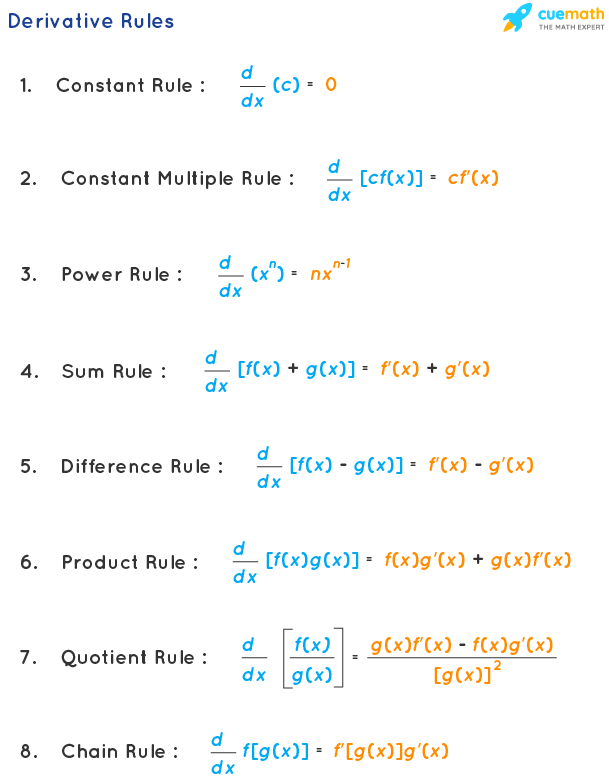

- Other is now n and self is x. Check out the pow function for complete notes. We also multiplied it because of the chain rule
- All we need left is to be able to subtract (neg/sub)

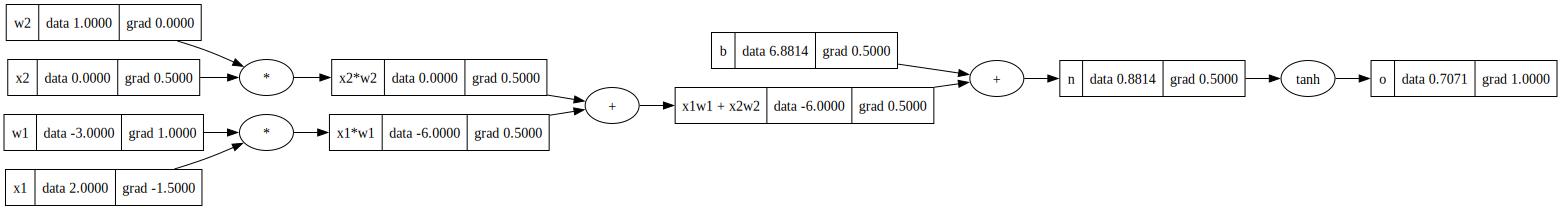

In [47]:
# inputs x1, x2 (2D)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2, of the neuron (synaptic strengths for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b ('cell body of neuron')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

> Notes
- Now that we have broken down tanh to its atomic expression, what can we expect to see with the graph that is being drawn?
- We can expect a longer graph because we have broken up tanh to a bunch of other operations but those operations are mathematically equivalent to tanh
- We should expect to see the same output (forward pass works) and because of the mathematical equivalence we expect to see the same backward pass on the leaf nodes (input)
- The reason for all of this is to practice a few more operations and writing more backwards passes along with the level in which you implement your operations is totally up to you. You can implement backward passes for tiny expressions like a single individual + or * or can just use tanh
- All of this is a sort of fake concept, all that matters is we have an input and some kind of an output and this output is a function of the inputs in some way. As long as you can do forward pass and the backward pass of that little operation, it doesn't matter what that operation is or how composite it is. 
- If you can write the local gradients, you can chain the gradient and you can continue back propagation so the designs of what those functions are is completely up to you

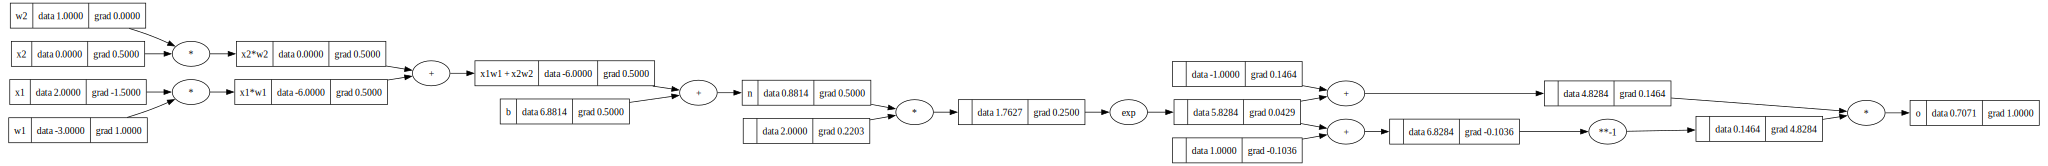

In [46]:
# inputs x1, x2 (2D)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2, of the neuron (synaptic strengths for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b ('cell body of neuron')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------
# output
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e -1) / (e + 1)
# ------
o.label = 'o'
o.backward()
draw_dot(o)

> Notes
- Now we are going to use the same thing (micrograd-land) but using a modern deep neural network library (PyTorch)
- PyTorch is something you would use in production
- Going to utilize PyTorch API
- We imported PyTorch then defined the value objects, micrograd is a scalar valued engine, so we only have scalar values (2.0) but in PyTorch everything is based around Tensors, which are n-dimensional arrays of scalars. We are casting the tensor to be .double() because python by default is using double precision for its floating point numbers so we want everything to be identical. By default the data type of the tensors will be float32, so only using a single precision float which is why we have the .double() so it has float64 just like in Python
- x1, x2, w1, w2 are leaf nodes so PyTorch assumes they do not require gradients so we need to explicitly say they require gradients (=True). Typically are false for efficiency reasons because you would usually not want gradients for leaf nodes like the inputs to the network (common case)
- The example below is going to construct scalar valued one element tensors
- Need to call .item() because it takes a single tensor of one element and it just returns that element, stripping out the tensor (o.data.item() will produce the same result)
- Can do the same thing like we did in micrograd but more efficient since we are working with these tensor objects and we can do lots of operations in parallel on all of these tensors

In [49]:
import torch

x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2 gradient:', x2.grad.item())
print('w2 gradient:', w2.grad.item())
print('w1 gradient:', w1.grad.item())
print('x1 gradient:', x1.grad.item())

0.7071066904050358
----
x2 gradient: 0.5000001283844369
w2 gradient: 0.0
w1 gradient: 1.0000002567688737
x1 gradient: -1.5000003851533106


In [50]:
# You'll typically work with tensors like this:
torch.Tensor([[1, 2, 3], [4, 5, 6]]) # 2 x 3 array of scalar values in a single compact representation

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [51]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])